In [1]:
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.cluster import KMeans


######################################################

from matplotlib import cm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer

from matplotlib.lines import Line2D

from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import ttest_ind
import matplotlib.colors as colors

print("done")

done


/home/kit/lti/rk3078/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# read in data 
pathData_train = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/dataset01_train.h5'
db_train = pd.read_hdf(pathData_train, 'df')
# pathData_test = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/dataset01_test.h5'
# db_test = pd.read_hdf(pathData_test, 'df')
# pathData_all = '/pfs/data5/home/kit/lti/rk3078/JupyterNotebooks/data/dataset01_all.h5'
# db_all = pd.read_hdf(pathData_all, 'df')

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
scatterColors=[]
cmap = plt.cm.get_cmap('plasma')
ks=np.linspace(0.7,0.9,2)
for zz in range(2):
    scatterColors.append(cmap(ks[zz]))
scatterColors=["coral","orange"]
pceLims=(5,17.5)
vocLims=(0.9,1.15)
jscLims=(16,22)
ffLims=(40,75)
fontSizeSetLarge=18
fontSizeSetMedium=14




0 maxValueLP725


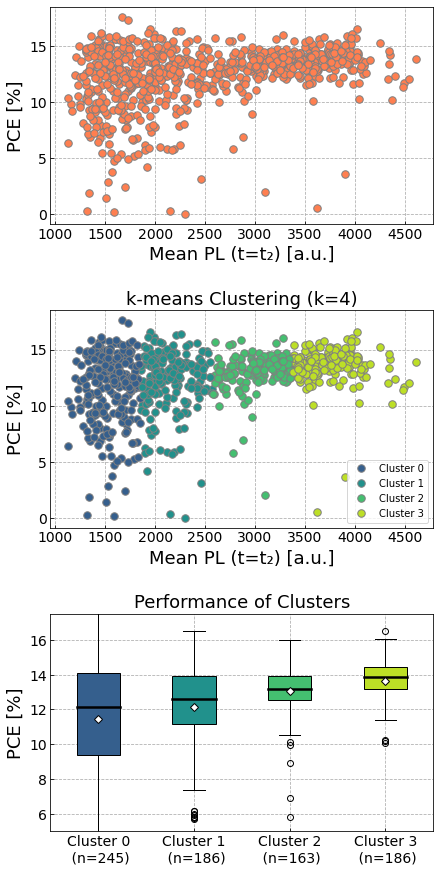

In [5]:
k=4
label,qP=("pce_backward",0)


minLim=np.percentile(np.array(db_train[label].dropna()),2)
maxLim=np.percentile(np.array(db_train[label].dropna()),98)-minLim



paramsList=["maxValueLP725","endPLLP725"]

for ix,param1 in enumerate(paramsList):
    print(ix,param1)

    fig,ax = plt.subplots(3,1, figsize=(6,12), constrained_layout=True)

    for x in range(len(db_train[label])):
        labelValue=db_train.loc[db_train.index[x],label]
        paramValue1=db_train.loc[db_train.index[x],param1]


        ax[0].plot(paramValue1,labelValue,".",color=scatterColors[ix], ms = 15, mec="gray")
        
        
    if ix==0:
        ax[0].set_xlabel("Mean PL (t=t\u2082) [a.u.]",fontsize=fontSizeSetLarge)
    elif ix==1:
        ax[0].set_xlabel("Mean PL (t=t\u2084) [a.u.]",fontsize=fontSizeSetLarge)  
    ax[0].set_ylabel("PCE [%]",fontsize=fontSizeSetLarge) 
    

    #########################################################################################################################################
    
    minimized=pd.DataFrame(db_train[param1])
    X = minimized.values.copy()   
    sc = MinMaxScaler()
    X = sc.fit_transform(X.reshape(-1,1))


    ks=np.linspace(0.3,0.9,k)
    color_list=[]
    cmap = plt.cm.get_cmap('viridis')
    for zz in range(len(ks)):
        color_list.append(cmap(ks[zz]))
            

    kmeans = KMeans(n_clusters=k, n_init=25, max_iter = 600, random_state=0)
    cluster_found = kmeans.fit_predict(X)
    
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    minimizedClusterAdded = minimized.set_index(cluster_found_sr, append=True )

    clusters = sorted(minimizedClusterAdded.index.get_level_values('cluster').unique())
    
    
    listPCE=[]
    listVOC=[]
    listJSC=[]
    listFF=[]
    listRS=[]
    listRSHUNT=[]

    for cluster, color in zip(clusters, color_list):    
        clusterDF=minimizedClusterAdded.xs(cluster, level=1)

        listPCE.append(db_train.loc[clusterDF.index,"pce_backward"])
        listVOC.append(db_train.loc[clusterDF.index,"voc_backward"])
        listJSC.append(db_train.loc[clusterDF.index,"jsc_backward"])
        listFF.append(db_train.loc[clusterDF.index,"ff_backward"])


    allLists=[listPCE,listVOC,listJSC,listFF]

    if True:
        medianList=[]
        for x in range(len(listPCE)):
            medianList.append(np.median(listPCE[x]))

        sortBy=sorted(range(len(medianList)), key=lambda k: medianList[k])
        newClusters=[]
        for a in range(len(sortBy)):
            newClusters.append(sortBy.index(a))

        cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(minimizedClusterAdded.index.get_level_values('cluster'))], name='cluster')

        #cluster_found_sorted = pd.Series(np.array(sortBy)[np.array(plotND2.index.get_level_values('cluster'))], name='cluster')

        minimizedClusterAdded = db_train.set_index(cluster_found_sorted, append=True )
        clusters = sorted(minimizedClusterAdded.index.get_level_values('cluster').unique())

        # medianList,sortBy
        listPCE2=np.array(listPCE,dtype=object)[sortBy]
        listVOC2=np.array(listVOC,dtype=object)[sortBy]
        listJSC2=np.array(listJSC,dtype=object)[sortBy]
        listFF2=np.array(listFF,dtype=object)[sortBy]

        allLists2=[listPCE2,listVOC2,listJSC2,listFF2]
        allLists=allLists2   


        
    xlabels=[]

    for x in range(len(clusters)):
        xlabels.append("Cluster " + str(clusters[x]))      # no rearrange cluster number #######################################################################
        #xlabels.append("cluster " + str(sortBy[x]))        # rearrange cluster number

    medianprops = dict(linestyle='-', linewidth=2.5, color='k')
    meanprops = dict(marker='D', markeredgecolor='black',markerfacecolor='white')
    
    
    pvparams=["PCE [%] backward","VOC [V] backward","JSC [mA/cm2] backward","FF backward"]
    

    bplot1=ax[2].boxplot(allLists[qP], medianprops=medianprops,  meanprops=meanprops, meanline=False, showmeans=True,patch_artist=True) 

    cnt=0
    for box in bplot1['boxes']:
        box.set(facecolor = color_list[cnt] ) 
        cnt+=1   
        
        
    ax[2].set_xticks(np.add(clusters,1), minor=False)

    nList=[]
    for cluster, color in zip(clusters, color_list):  

        clusterDF=minimizedClusterAdded.xs(cluster, level=1)
        nList.append("\n (n=" +str(len(clusterDF))+")")
    newList=[]
    for yy in range(len(xlabels)):
        newList.append(xlabels[yy]+nList[yy])

    ax[2].set_xticklabels(newList, fontdict=None, minor=False,fontsize=fontSizeSetMedium)
    ax[2].set_ylabel("PCE [%]",fontsize=fontSizeSetLarge)  

    

    cnt=0
    for box in bplot1['boxes']:
        box.set(facecolor = color_list[cnt] ) 
        cnt+=1   

    nList=[]
    for cluster, color in zip(clusters, color_list):  
        #print(cluster, color)
        clusterDF=minimizedClusterAdded.xs(cluster, level=1)
        nList.append("\n (n=" +str(len(clusterDF))+")")
 

    for x in range(len(minimizedClusterAdded)):
        clusterNo=minimizedClusterAdded.index.get_level_values("cluster")[x]
        labelValue=minimizedClusterAdded.loc[minimizedClusterAdded.index[x],label]
        paramValue1=minimizedClusterAdded.loc[minimizedClusterAdded.index[x],param1]


        ax[1].plot(paramValue1,labelValue,".",color=color_list[clusterNo],ms = 15, mec="gray")
        
    patchList=[]
    for xx in range(len(clusters)):
        patchList.append(Line2D([0], [0], marker='.', color='w', label=xlabels[xx], markerfacecolor=color_list[xx], markersize=15,mec='gray'))
        #patchList.append(mpatches.Patch.Circle(color=color_list[clustNum], label="cluster "+ str(clustNum))
    
    ax[1].legend(handles=patchList, loc="lower right", fontsize=10)
    

    
    if ix==0:
        ax[1].set_xlabel("Mean PL (t=t\u2082) [a.u.]",fontsize=fontSizeSetLarge)
    elif ix==1:
        ax[1].set_xlabel("Mean PL (t=t\u2084) [a.u.]",fontsize=fontSizeSetLarge)  
        
    ax[1].set_ylabel("PCE [%]",fontsize=fontSizeSetLarge)  
    

    ax[1].set_title("\nk-means Clustering (k="+ str(k)+")", fontsize=fontSizeSetLarge)    
    ax[2].set_title("\nPerformance of Clusters", fontsize=fontSizeSetLarge)  
  
    ax[2].set_ylim(pceLims)
    ax[0].grid(which="both", linestyle='--')
    ax[1].grid(which="both", linestyle='--')
    ax[2].grid(which="both", linestyle='--')
    ax[0].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
    ax[1].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
    ax[2].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)

    plt.show()


    ### statistics:

    break

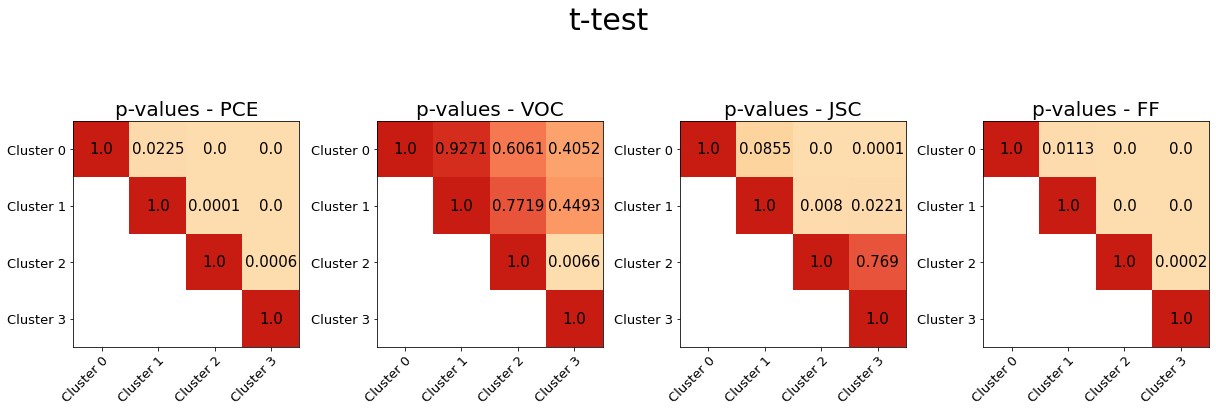

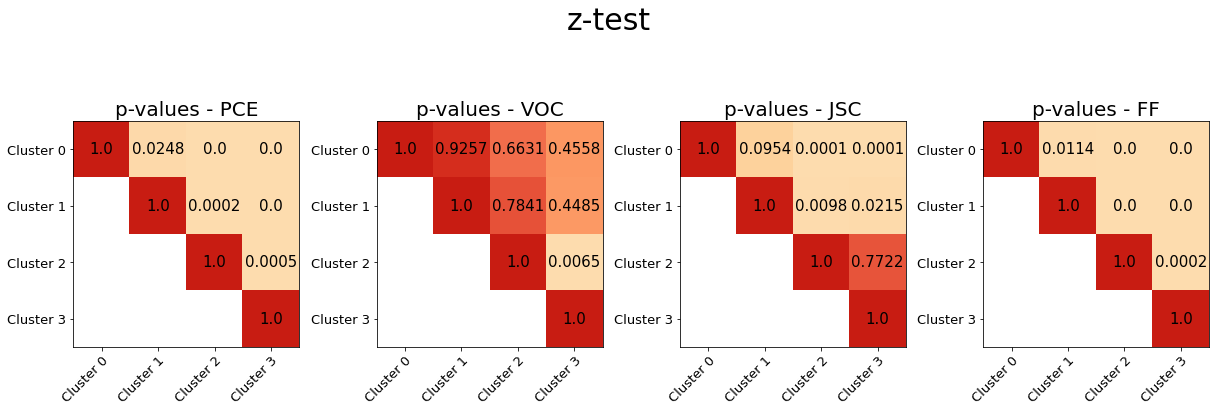

In [6]:
cmap="PiYG_r"
cmap=truncate_colormap(plt.get_cmap('viridis'), 0.4, 0.99)
cmap=truncate_colormap(plt.get_cmap('OrRd'), 0.2, 0.8)

saveStatistics=False
roundTo=4
fig,ax=plt.subplots(1,4, figsize=(17,6))
pvparameterNames = ["PCE", "VOC", "JSC", "FF"]
for ix2,pvparameter in enumerate(pvparameterNames):
    pValues_tTest=np.zeros((4,4))
    for a in range(4):
        for b in range(4):
            pValues_tTest[a,b]=np.round(ttest_ind(allLists[ix2][a], allLists[ix2][b], equal_var=False, alternative="two-sided")[1],5)

    clusterNames = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]
    data=np.triu(pValues_tTest,k=0)
    data[1,0]=np.nan
    data[2,0]=np.nan
    data[3,0]=np.nan
    data[2,1]=np.nan
    data[3,1]=np.nan
    data[3,2]=np.nan
    im = ax[ix2].imshow(data, cmap=cmap)

    ax[ix2].set_xticks(np.arange(len(clusterNames)), labels=clusterNames, fontsize=13)
    ax[ix2].set_yticks(np.arange(len(clusterNames)), labels=clusterNames, fontsize=13)
    plt.setp(ax[ix2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(clusterNames)):
        for j in range(len(clusterNames)):
            if j>=i:
                text = ax[ix2].text(j, i, round(pValues_tTest[i, j],roundTo),
                               ha="center", va="center", color="k",fontsize=15)

    ax[ix2].set_title("p-values - " + str(pvparameter), fontsize=20)

fig.suptitle("t-test", fontsize=30)   
fig.tight_layout()





fig,ax=plt.subplots(1,4, figsize=(17,6))
for ix3,pvparameter in enumerate(pvparameterNames):
    pValues_zTest=np.zeros((4,4))
    for a in range(4):
        for b in range(4):
            pValues_zTest[a,b]=np.round(ztest(allLists[ix3][a], allLists[ix3][b], value=0)[1],5)

    data=np.triu(pValues_zTest,k=0)
    data[1,0]=np.nan
    data[2,0]=np.nan
    data[3,0]=np.nan
    data[2,1]=np.nan
    data[3,1]=np.nan
    data[3,2]=np.nan
    im = ax[ix3].imshow(data, cmap=cmap)

    ax[ix3].set_xticks(np.arange(len(clusterNames)), labels=clusterNames, fontsize=13)
    ax[ix3].set_yticks(np.arange(len(clusterNames)), labels=clusterNames, fontsize=13)
    plt.setp(ax[ix3].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(clusterNames)):
        for j in range(len(clusterNames)):
            if j>=i:
                text = ax[ix3].text(j, i, round(pValues_zTest[i, j],roundTo),
                               ha="center", va="center", color="k",fontsize=15)

    ax[ix3].set_title("p-values - " + str(pvparameter), fontsize=20)

fig.suptitle("z-test", fontsize=30)   
fig.tight_layout()

plt.show()

In [7]:
clusters_all_pvparams=allLists

------------ PCE ------------


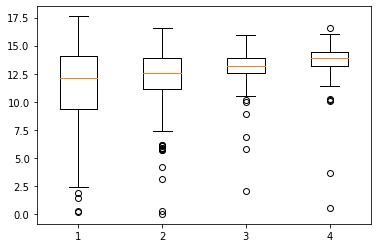

[[1.00000000e+00 2.47531607e-02 5.32407737e-09 2.37341393e-17]
 [2.47531607e-02 1.00000000e+00 1.80477855e-04 1.08263364e-10]
 [5.32407737e-09 1.80477855e-04 1.00000000e+00 5.29048851e-04]
 [2.37341393e-17 1.08263364e-10 5.29048851e-04 1.00000000e+00]]
------------ VOC ------------


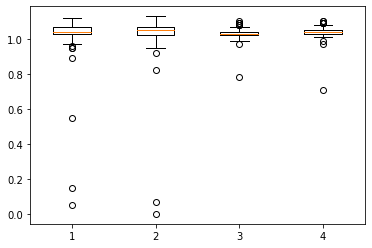

[[1.         0.92566163 0.66307351 0.45578273]
 [0.92566163 1.         0.78413446 0.44847715]
 [0.66307351 0.78413446 1.         0.00652662]
 [0.45578273 0.44847715 0.00652662 1.        ]]
------------ JSC ------------


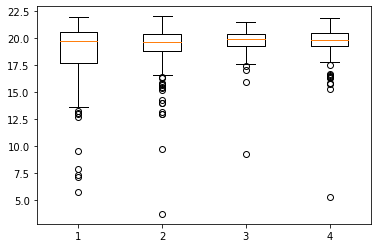

[[1.00000000e+00 9.54304803e-02 8.69634444e-05 1.46368376e-04]
 [9.54304803e-02 1.00000000e+00 9.79680230e-03 2.14654644e-02]
 [8.69634444e-05 9.79680230e-03 1.00000000e+00 7.72202362e-01]
 [1.46368376e-04 2.14654644e-02 7.72202362e-01 1.00000000e+00]]
------------ FF ------------


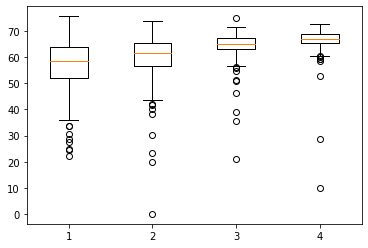

[[1.00000000e+00 1.13557548e-02 2.22232725e-15 5.53429278e-30]
 [1.13557548e-02 1.00000000e+00 2.63767078e-07 4.49344812e-17]
 [2.22232725e-15 2.63767078e-07 1.00000000e+00 1.58857790e-04]
 [5.53429278e-30 4.49344812e-17 1.58857790e-04 1.00000000e+00]]


In [8]:
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import ttest_ind

# clusters_all_pvparams: nested list containing all 4 pvParameters and each of them contains the 4 clusters 

for pvparam,pvparameter in enumerate(pvparameterNames):
    print("------------", pvparameter,"------------")
    pValues_zTest=np.zeros((4,4))
    pValues_tTest=np.zeros((4,4))
    plt.boxplot(clusters_all_pvparams[pvparam]) 
    plt.show()
    for clusterA in range(4):
        for clusterB in range(4):
            pValues_zTest[clusterA,clusterB]=ztest(clusters_all_pvparams[pvparam][clusterA], 
                                                   clusters_all_pvparams[pvparam][clusterB], value=0)[1]
            pValues_tTest[clusterA,clusterB]=ttest_ind(clusters_all_pvparams[pvparam][clusterA], 
                                                       clusters_all_pvparams[pvparam][clusterB], equal_var=False, alternative="two-sided")[1]
    print(pValues_zTest)

    